# Synthesis Project I: SEIR Model

In this project, you will apply much of what we've already done in this class to address a contemporary issue; *when will we reach COVID-19 herd immunity?* We will estimate the time this occurs using a number of tools that you are now familiar with, 

* object-oriented Python programming,
* solving ordinary differential equations, 
* MCMC methods for uncertainty quantification and
* management and visualization of intermediate volumes of data.

In addition to these now familiar tools, we will be learning more about *optimization* in the context of *inverse modeling*.

## Basis
The basis for our work can be found in [this paper](https://www.nature.com/articles/s41598-020-77628-4.pdf). Here, we learn that a relatively simple set of ODEs can be solved to model the propagation of an infectious disease through a human population. This model is appropriate for a disease that has a period where people are infected, contagious, but asymptomatic. We use the term "exposed" for this group of people. The key concept in the paper is best related through the rate of change equations:

$\begin{align}
\frac{dS}{dt} &= -\beta S ( I + qE) / N\\
\frac{dE}{dt} &=  \beta S ( I + qE) / N - \frac{E}{\delta} \\
\frac{dI}{dt} &=  \frac{E}{\delta} - \frac{I}{\gamma}\\
\frac{dR}{dt} &=   \frac{I}{\gamma} 
\end{align}$

Where $S$ is the susceptible population, $E$ the exposed, $I$ the infected, and $R$ the recovered. Observe that every term on the right hand side is repeated twice - once negative and once positive. This reflects that the dynamics take people away from one population and puts them into another. For example, $-\beta S ( I + qE) / N$ is taking susceptible people and moving them to the exposed population. The rate this is occurring is $\beta$ and both infected and exposed can infect a susceptible. However, exposed are $q$ less likely to infect a susceptible because they aren't sneezing or coughing. $N$ is the population of the unit being modeled (state or country), and dividing by $N$ makes the calculations independent of population and working on population *fractions*. $\delta$ is the time between exposure and symptoms, and $\gamma$ the time people are sick.

Of course, nothing so high-profile as a Nature paper can ever be so easy. Much of the paper is committed to compartmentalizing these equations by age. However, for our purposes, the above is sophisticated enough. Indeed, one can reasonably ask if the compartmental models don't just introduce more parameters that are uncertain and produce *over-fitting*.

### Problem 0: Parameters
Read the paper carefully to find acceptable values for the parameters. Of critical interest will be:
* $\beta$ the infection rate
* $\delta$, the time between exposure and infection
* $\gamma$, the time of infection
* $q$, the decrease in infection rate that exposed individuals have when compared to the infected.
* $d$ the death rate, or fraction of infected that die instead of recover.

Create a dictionary or other data type to store these parameters in an effective way, such that code retrieving data is easy to read, and changes to parameter values are possible.


### Problem 1: Coding up the RHS
Let's continue our assignment by coding up the right hand side of the above equations. 

## Inverse Modeling

In this assignment we will employ a powerful method called *inverse modeling*. You are now accustomed  to doing *forward-modeling* - initial values and parameters are set, and and you are interested in future states. The bullet problem is a great example of this. So is n-body. The results of interest is found throughout or at the end of the simulation. The business of simulation is starting with what you know, and getting from the beginning to the end.

In inverse modeling, you are going to run a model as you did before, but instead of focusing solely on the results, you are going to focus on the input parameters that give particular results. Said more specifically:

* ***forward model*** - set the inputs and study the output.
* ***inverse model*** - determine the inputs required to minimize the difference between outputs and observations, hence *determining unknown inputs*. 

Differences between model and observation can be computed with sum square error or another error metric. Care must be taken to ensure model outputs are directly comparable to data in terms of both observation, and reconciliation of state.

As it happens, you've done a simple inverse problem already. You had to find the angle to fire the gun in order to have the bullet hit zero at some range, often 200 meters. In that problem, the angle would be the *control parameter*, and the forward model was your friction model applied to a 2D projectile traveling in a gravitational field. The error was simply looking at if the zero was reached at the desired distance.

As with many new ideas, examples help. Now, let's apply inverse modeling to COVID-19.

### Example COVID-19

In the global pandemic, there are some things that we know we don't know and others that we might know. For example, it's very hard to know the number of individuals infected. We don't have enough testing, and too many people are asymptomatic or don't report their illness. That's a shame, because the infected are a state variable. 

But, we probably know how many died. Death is serious business, and tends to be recorded accurately. Of course, there are some questions, many of the dead have multiple medical issues. But, for the sake of this assignment, let's assume we know COVID-19 deaths in the US.

However, the number of infected is a state variable, and not deaths. So, we need to make some adjustments there. Let's figure out how to make death a state variable.

As to the inverse model, and the control parameter; look back at those SEIR equations. What might be a parameter that we can adjust to bring the state into consistency with observations of death? We are looking for something that is not well known, but critical to disease dynamics.

$\beta$, or the infection rate is a good place to look. This is how easily the disease spreads from person to person. It is a number that is inherent to the disease; a reflection of how much virus is in the sinuses, how often, and how forcefully people cough or sneeze, how long lived the virus is in the open environment, outside a body, etc.

But, $\beta$ can also be lowered by *policies*. So called non-pharmaceutical interventions. Wearing a mask lowers $\beta$. Social distancing lowers $\beta$. Closing restaurants and bars, and beaches. Policies are clearly having a big impact on $\beta$.

So, our inverse parameter should be time dependent, $\beta(t)$, reflecting how people move into and out of compliance with non-pharmaceutical interventions. We will make no assumptions about the way this curve varies in time.

It's worth noting that epidemiologists don't talk about $beta$. Rather, they speak of $R_o$, which has a very clear interpretation: it is the number of cases that occur per case. How many people, on average, become infected from an infected person. In our model, it is the product $\beta \gamma$ (not $\beta (\gamma + qE)$ for reasons I'm not sure I understand), where $\gamma$ is the time a person is infectious, and $E$ the time they are exposed, shedding virus,and asymptomatic. $q$ reflects how much less infectious they are during this initial period.

$R_o$ is a good parameter to think about because if it is less than 1, the disease is on its way out.The infected exponentially decay. If it is greater than 1, then the disease is propagating, *exponentially*.

So, let's approach the problem as follows:

* Death rates will be compared to the model output and minimized.
* The parameter $\beta$ will be used to adjust the model and minimize differences with observation.
* The death-rate will also be adjusted to meet the observations.
* $\beta$ will be converted to $R_o$ to make results easier to interpret.

#### Problem 2: Adding the dead to the ODEs
At this stage - there is a lot to understand, but not a lot to do. As a test of your understanding of the ODEs, add the death rate to create a 5th state variable, the dead $D$. Express this as you do the other variables, as a rate of change computed from fractions of the population. You will have to introduce another key variable, the death rate, which is multiplied by the appropriate populations. Hint - death is a morbid form of recovery.

#### Problem 3: Using a Polynomial for $\beta(t)$

The parameter $\beta(t)$ will be time dependent and adjusted to meet observations. So, how to get a smoothly varying function that reflects the changes that have occurred in the infectiousness? 

Let's use a `numpy Polynomial` object. So there is some consistency in our results, make it a **6th order** polynomial. Below, master the instantiation of the object, and how an array of coefficients can be used to change the coefficients in the `Polynomial` object.

Place the polynomial into the parameters data structure.


---
**Testing Polynomial functionality**

---

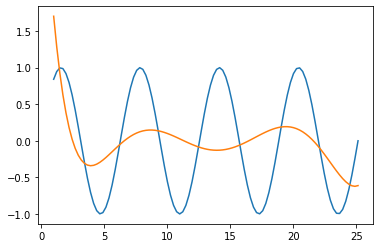

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(1, 8*np.pi, 100)
y_data = np.sin(x)
coef = np.polynomial.polynomial.polyfit(x, y_data, 6)
poly_func = np.polynomial.polynomial.Polynomial(coef)
y_fit = poly_func(x)

plt.plot(x, y_data, label='data')
plt.plot(x, y_fit, label='model')
plt.show()

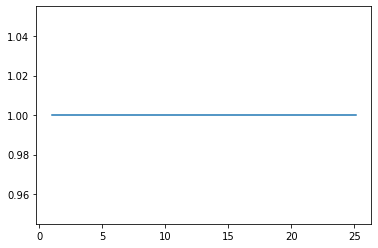

In [2]:
x = np.linspace(1, 8*np.pi, 100)
y_data = np.sin(x)
poly_func = np.polynomial.polynomial.Polynomial(np.array((1,0,0,0,0,0)))

y_fit = poly_func(x)

plt.plot(x, y_fit, label='model')
plt.show()

### Critical Methods

OK, by now writing the RHS was probably pretty simple for you. Now let's write some infrastructure that will make this assignment doable. Each of the following should be a method, perhaps with some helper methods. I suggest an object oriented approach, as you will need to interrogate this object with many different parameters.

#### Problem 4: Acquire data
Many of the data files that drive this simulation will be in `csv` format. Two important ones are [death counts](https://www.cdc.gov/nchs/nvss/vsrr/covid19/index.htm) and [population estimates](https://www.census.gov/data/tables/time-series/demo/popest/2010s-national-total.html#par_textimage_2011805803).

Data acquisition facilities can and should live outside the class storing the ODE and tools for solving it. It should return data for a named location. Methods should return `numpy` arrays of numbers and lists of `datetime` objects. 

Before starting, familiarize yourself with `datetime` and `csv` Python modules, as they will be used here.

#### Problem 5: Set location
This method *will* live in the object that has the following functions. Think of location as a key parameter that sets data fields. Write a function that uses the data acquisition tools to get the data needed. Think carefully about the need to reconcile days since the model started running (that's the model output) with the calendar day, which you get in the data set.

#### Problem 6: Set parameters
While you will set the key parameters upon initialization of the simulation, it will also be important that you can change them and re-run. Add a method that performs the typical tasks of the `__init__` method and sets parameters.

#### Problem 7: Get the SSE
This function can be called to numerically solve the system of ODEs and compare it to the data, finding the sum square error (SSE). Rather than use your own ODE solvers, use the `scipy.integrte.solve_ivp` module. The differences in signature are mostly superficial and this should be a quick change. 

The method will need access to the current set of parameters for the model. 

This method should then compare the deaths computed to the deaths observed. This is mostly easy so long as you remember:

* The `datetime` objects can be differenced to get the number of days, so find number of days from the first day you have data for each data point. This will make the ODE output directly comparable to the observations.
* The `solve_ivp` can be given a `t_eval` list that specifies when you need to have a state estimate. Use this to make sure the model output can be directly compared to the observations.
* The model will return the cumulative sum of the deaths. The data is reported in deaths per week. Make necessary adjustments so that you compare deaths per week.

This function should return the sum square error, a single scalar value.

#### Problem 8: Plot results

At the very least, create a 4 panel plot with the following views:
* Deaths modeled and deaths observed as a function of time.
* $R_o$ as a function of time.
* The susceptable, infected and recovered populations as a function of time.
* The fraction of the population that has recovered as a function time.

Observe that by passing a list of dates you can get a nicely formated time axis.


---
**Testing data IO functionality**

---

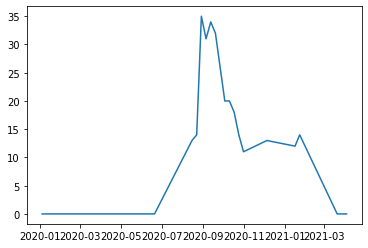

total deaths:307.0


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize,rosen

# data from https://data.cdc.gov/NCHS/Provisional-COVID-19-Death-Counts-by-Week-Ending-D/r8kw-7aab
raw_data = pd.read_csv("Provisional_COVID-19_Death_Counts_by_Week_Ending_Date_and_State.csv", parse_dates=["Week Ending Date"])

death_data = raw_data[["Week Ending Date", "COVID-19 Deaths", "State"]].dropna()

def get_state(state, data):
    return data.where(data["State"] == state).dropna()

Hawaii = get_state("Hawaii", death_data)

plt.plot(Hawaii["Week Ending Date"], Hawaii["COVID-19 Deaths"])
plt.show()
total_deaths = Hawaii["COVID-19 Deaths"].sum()
print(f"total deaths:{total_deaths}")

---
**SEIR Object**

---

Optimization terminated successfully.
         Current function value: 15952596.030299
         Iterations: 2289
         Function evaluations: 3474


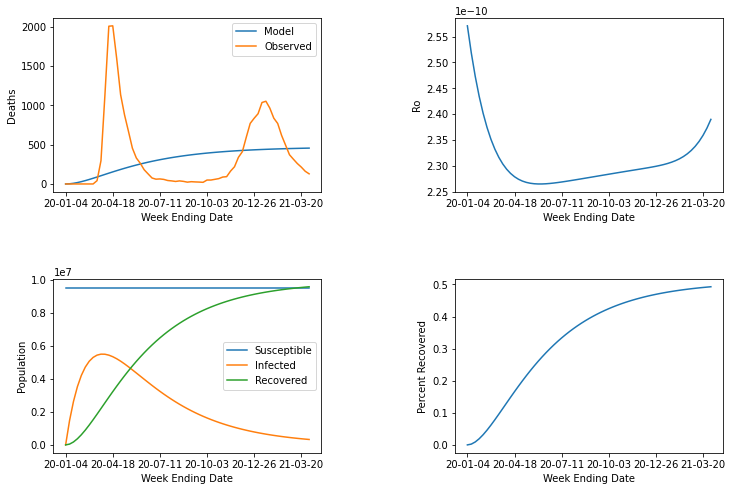

In [9]:
from scipy.optimize import minimize
import scipy.integrate as ODE
import pandas as pd
import numpy as np

class SEIR_ODE:
    def __init__(self, state):
        self.beta = 0.8   # infectiousness of infected person, overridden in function calls
        self.q = 0.5        # infectiousness of exposed person
        self.delta = 6      # time of exposure to infection
        self.gama = 16      # recovery rate
        self.omega = 0.01   # death rate, overridden in function calls
        self.N = None     # set in set_location()
        self.init_infect = 0.001

        self.beta_func = None   # set when state is chosen
        self.params = None      # set when state is chosen

        self.data_file = "Provisional_COVID-19_Death_Counts_by_Week_Ending_Date_and_State.csv"
        self.data = self.read_data()
        self.population_data = pd.read_csv("Population.csv")[["Area", "2019"]]
        self.state_data = self.set_location(state)

        # model outputs
        self.model_deaths = None
        self.observed_deaths = None
        self.ODE_output = None


    def set_parameters(self, param_dict):
        self.beta = param_dict["beta"] if param_dict["beta"] is not None else self.beta
        self.q = param_dict["q"] if param_dict ["q"] is not None else self.q
        self.delta = param_dict["delta"] if param_dict["delta"] is not None else self.delta
        self.gama = param_dict["gama"] if param_dict["gama"] is not None else self.gama
        self.omega = param_dict["omega"] if param_dict["omega"] is not None else self.omega
        self.N = param_dict["N"] if param_dict["N"] is not None else self.N

        return None

    def SEIR(self, t, y):
        """
        Accepts the state of the system as:
        y[0] = Suseptable population - never impacted by the disease
        y[1] = Exposed population - has the disease, but not yet manifesting symptoms
        y[2] = Infected population - has the disease, and symptoms
        y[3] = Recovered population - has recovered from the disease, and is no longer suseptable
        y[4] = Dead population - recovered in the form of death

        This function returns the time deriviative of the state, dydt, and uses a dictionary
        of parameters p.
        """
        S, E, I, R, D = y
        beta = self.beta_func(t)
        d_S = -beta * S * (I + self.q * E) / self.N
        d_E = beta * S * (I + self.q * E) / self.N - E / self.delta
        d_I = E / self.delta - I / self.gama
        d_R = I / self.gama * (1 - self.omega)
        d_D = I / self.gama * self.omega

        return np.array((d_S, d_E, d_I, d_R, d_D))

    def read_data(self):
        raw_data = pd.read_csv(self.data_file, parse_dates=["Week Ending Date"])
        death_data = raw_data[["Week Ending Date", "COVID-19 Deaths", "State"]].dropna()

        return death_data

    def set_location(self, state):
        filtered_state_data = self.data.where(self.data["State"] == state).dropna()

        x = np.arange(len(filtered_state_data["COVID-19 Deaths"].values))
        y = np.full(x.shape, self.beta)
        self.beta_func = np.polynomial.polynomial.Polynomial.fit(x, y, deg=6, domain=[0, len(x)])

        self.params = self.beta_func.coef.copy()
        self.params = np.append(self.beta_func.coef, self.omega)
        self.params = np.append(self.params, self.init_infect)

        row = self.population_data.loc[self.population_data["Area"] == f".{state}"]
        self.N = int(row["2019"].values[0].replace(",", ""))

        return filtered_state_data

    def ODE_forward(self):

        # get number of time points
        time_final = self.state_data.shape[0]
        eval_points = np.arange(time_final)

        # initialize the populations
        ode_state = np.array((self.N - (self.init_infect * self.N), self.init_infect * self.N, 0, 0, 0))

        # run the ode solver
        model_pred = ODE.solve_ivp(self.SEIR, (0, time_final), ode_state, t_eval=eval_points)

        return model_pred


    def get_SSE(self, params):
        """
        The hardest working routine - will
        1. accept a set of parameters for the polynomial coefficients and the death rate
        2. run the SEIR model using the ODE solver, solve_ivp
        3. return an Sum Square Error by comparing model result to data.
        :param params: 7 params for polynomial and 1 for death rate 1 for initial exposed population percentage
        :return:
        """
        # get number of time points
        time_final = self.state_data.shape[0]
        eval_points = np.arange(time_final + 1)

        # unpack parameters, set beta and omega class members
        self.beta_func.coef = params[:7].copy()
        self.beta = self.beta_func(eval_points)
        self.omega = params[7]
        self.init_infect = params[8]

        if np.any(self.beta <= 0):
            return 1e26
        if self.omega < 0 or self.omega > 1:
            return 1e26

        self.ODE_output = self.ODE_forward()
        self.model_deaths = self.ODE_output.y[4,:]

        self.observed_deaths = self.state_data['COVID-19 Deaths'].values

        SSE = np.sum(np.square(self.observed_deaths - self.model_deaths))
        return SSE

        # if self.observed_deaths.size == self.model_deaths.size:
        #     SSE = np.sum(np.square(self.observed_deaths - self.model_deaths))
        #     return SSE
        # else:
        #     return 1e26


    def plot_results(self):
        """
        create a 4 panel plot with the following views:

        * Deaths modeled and deaths observed as a function of time.
        * 𝑅𝑜  as a function of time.
        * The susceptable, infected and recovered populations as a function of time.
        * The fraction of the population that has recovered as a function time.
        """

        date_times = self.state_data["Week Ending Date"].values
        x = [np.datetime_as_string(date)[2:10] for date in date_times]

        fig = plt.figure(figsize=(12,8))
        gs = fig.add_gridspec(2,2, wspace=0.5, hspace=0.5)
        axs = gs.subplots()


        axs[0][0].set(xlabel="Week Ending Date", ylabel="Deaths")
        axs[0][0].plot(x, self.ODE_output.y[4, :], label="Model")
        axs[0][0].plot(x, self.observed_deaths, label="Observed")
        axs[0][0].set_xticks(x[::12])
        axs[0][0].legend()

        axs[0][1].set(xlabel="Week Ending Date", ylabel="Ro")
        axs[0][1].plot(x, self.beta_func(np.arange(len(x))) * self.gama)
        axs[0][1].set_xticks(x[::12])

        axs[1][0].set(xlabel="Week Ending Date", ylabel="Population")
        axs[1][0].plot(x, self.ODE_output.y[0, :], label="Susceptible")
        axs[1][0].plot(x, self.ODE_output.y[2, :], label="Infected")
        axs[1][0].plot(x, self.ODE_output.y[3, :], label="Recovered")
        axs[1][0].set_xticks(x[::12])
        axs[1][0].legend()


        axs[1][1].set(xlabel="Week Ending Date", ylabel="Percent Recovered")
        axs[1][1].plot(x, self.ODE_output.y[3, :]/self.N, label="Recovered")
        axs[1][1].set_xticks(x[::12])

        plt.show()

        return None

    def optimize(self):
        return minimize(self.get_SSE, self.params, method='Nelder-Mead', options={'disp': True, 'maxiter': 1e4})

# # for debugging
# ode_test = SEIR_ODE("Hawaii")
# error = ode_test.get_SSE(ode_test.params)
# ode_test.plot_results()

SEIRD = SEIR_ODE("New York")
# error = SEIRD.get_SSE(SEIRD.params)
# SEIRD.plot_results()


result = SEIRD.optimize()
SEIRD.plot_results()

In [29]:
print(SEIRD.beta_func(np.arange(63)))

[3.56910361e-02 2.80260283e-02 2.15321041e-02 1.60982570e-02
 1.16217287e-02 8.00758569e-03 5.16830484e-03 3.02336835e-03
 1.49886809e-03 5.27119270e-04 4.62832799e-05 4.53539983e-13
 3.37029322e-04 1.01090201e-03 1.97957989e-03 3.20512531e-03
 4.65337995e-03 6.29365291e-03 8.09841814e-03 1.00430212e-02
 1.21053951e-02 1.42657861e-02 1.65064878e-02 1.88115855e-02
 2.11667092e-02 2.35587967e-02 2.59758649e-02 2.84067912e-02
 3.08411041e-02 3.32687834e-02 3.56800684e-02 3.80652772e-02
 4.04146342e-02 4.27181072e-02 4.49652535e-02 4.71450760e-02
 4.92458880e-02 5.12551878e-02 5.31595416e-02 5.49444774e-02
 5.65943866e-02 5.80924357e-02 5.94204872e-02 6.05590300e-02
 6.14871185e-02 6.21823216e-02 6.26206810e-02 6.27766782e-02
 6.26232116e-02 6.21315823e-02 6.12714899e-02 6.00110365e-02
 5.83167412e-02 5.61535631e-02 5.34849341e-02 5.02728008e-02
 4.64776754e-02 4.20586969e-02 3.69737000e-02 3.11792953e-02
 2.46309568e-02 1.72831205e-02 9.08929079e-03]
